In [587]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [588]:
torch.manual_seed(123456789)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We set $d=1000, n=300$ and initialize the model 

$$f(x;\theta)=\langle a\odot b,x \rangle$$

by $a_j,b_j\stackrel{iid}{\sim} \mathcal{N}(0,1)$ for $j=1,\dots,d$.

In [589]:
d = 1000
n = 300
n_test = 3000

In [590]:
class DiagonalNet(torch.nn.Module):
    def __init__(self, d):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(d))
        self.b = torch.nn.Parameter(torch.randn(d))

    def forward(self, x):
        return x @ (self.a * self.b)

Consider $f^*(x)=\beta_*^Tx$ with  $\beta_* = (1,1,1,0,\cdots,0)$, for which $\|\beta_*\|_1=3$. 

In [591]:
beta_star = torch.zeros(d)
beta_star[:3] = 1.0

def teacher(x):
    return x @ beta_star

In [592]:
X_train = 2 * torch.rand(n, d, device=device) - 1
y_train = teacher(X_train)

X_train, y_train = X_train.to(device), y_train.to(device)

X_test = 2 * torch.rand(n_test, d, device=device) - 1
y_test = teacher(X_test)

X_test, y_test = X_test.to(device), y_test.to(device)

Then we define mesuarements of sharpness: $\mathrm{Tr}(G(\theta))$, $\|G(\theta)\|_{F}$, $\|G(\theta)\|$, where $G(\theta)= \dfrac{1}{n} \sum \limits_{i=1}^{n} g_i(\theta) g_i(\theta)^T$ is the associate empirical Fisher matrix.

In [593]:
def test_error(model):
    with torch.no_grad():
        pred = model(X_test)
        return (torch.sign(pred) != torch.sign(y_test)).float().mean().item()

def calculate_metrics(model, X):
    dtype = next(model.parameters()).dtype
    device = next(model.parameters()).device

    X = X.to(device=device, dtype=dtype)

    grads = []

    for i in range(X.shape[0]):
        model.zero_grad(set_to_none=True)

        out = model(X[i:i+1]) 
        out.backward()

        g = torch.cat([
            model.a.grad.flatten(),
            model.b.grad.flatten(),
        ])

        grads.append(g)

    J = torch.stack(grads)
    F = (J.T @ J) / J.shape[0]  

    trace = torch.trace(F).item()
    frob = torch.norm(F, p='fro').item()

    v = torch.randn(F.shape[0], device=F.device, dtype=F.dtype)
    v = v / (v.norm() + 1e-16)
    for _ in range(30):
        v = F @ v
        v = v / (v.norm() + 1e-16)
    op_norm = torch.dot(v, F @ v).item()

    return [trace, frob, op_norm]

In [594]:
def train_sgd(lr, T=20000, clip=100.0):
    model = DiagonalNet(d).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    threshold = 2.0 / lr
    fisher_trace = 0.0
    beta = 0.995

    counter = 0
    patience = 5

    for t in range(T):
        i = torch.randint(0, n, (1,))
        x = X_train[i].to(device=device)
        y = y_train[i].to(device=device)

        pred = model(x)
        loss = 0.5 * (pred - y).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        if total_norm.item() < 1e-5:
            break

        optimizer.step()

    return model

In [595]:
def train_gd(lr, T=20000, clip=100.0):
    model = DiagonalNet(d).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=T)

    for t in range(T):
        pred = model(X_train)
        loss = 0.5 * (pred - y_train).pow(2).mean()

        model.zero_grad()
        loss.backward()

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        if total_norm.item() < 1e-5:
            break

        optimizer.step()
        scheduler.step()

    return model

In [596]:
lrs = np.logspace(-2.4, -0.9, 6)
eta_ref = []
for i in range(len(lrs)):
    eta_ref.append(float(2 / lrs[i]))

In [597]:
sgd_error, gd_error = [], []
sgd_metrics = {
    "trace": [],
    "frob": [],
    "op_norm": []
}

gd_metrics = {
    "trace": [],
    "frob": [],
    "op_norm": []
}

clip = 50.0

for lr in lrs:
    model_sgd = train_sgd(lr, T=80000, clip=clip)
    model_gd  = train_gd(lr, T=80000, clip=clip)

    sgd_error.append(test_error(model_sgd))
    gd_error.append(test_error(model_gd))

    current_sgd_metrics = calculate_metrics(model_sgd, X_train)

    sgd_metrics["trace"].append(current_sgd_metrics[0])
    sgd_metrics["frob"].append(current_sgd_metrics[1])
    sgd_metrics["op_norm"].append(current_sgd_metrics[2])

    current_gd_metrics = calculate_metrics(model_gd, X_train)

    gd_metrics["trace"].append(current_gd_metrics[0])
    gd_metrics["frob"].append(current_gd_metrics[1])
    gd_metrics["op_norm"].append(current_gd_metrics[2])


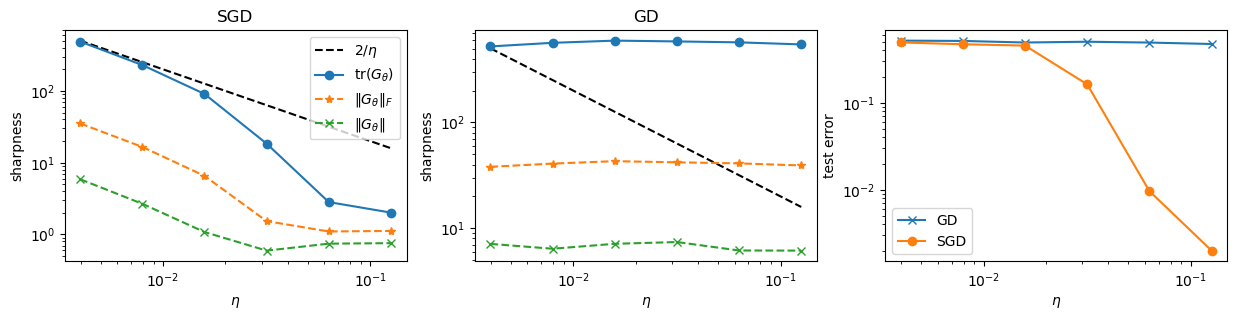

In [598]:
plt.figure(figsize=(15,3))

plt.subplot(1, 3, 1)
plt.loglog(lrs, eta_ref, "--", label=r"$2/\eta$", color="black")
plt.loglog(lrs, sgd_metrics["trace"], "o-", label=r"tr$(G_{\theta})$")
plt.loglog(lrs, sgd_metrics["frob"], "*--", label=r"$\|G_{\theta}\|_{F}$")
plt.loglog(lrs, sgd_metrics["op_norm"], "x--", label=r"$\|G_{\theta}\|$")
plt.xlabel(r"$\eta$")
plt.ylabel("sharpness")
plt.title("SGD")
plt.legend()

plt.subplot(1, 3, 2)
plt.loglog(lrs, eta_ref, "--", label=r"$2/\eta$", color="black")
plt.loglog(lrs, gd_metrics["trace"], "o-", label=r"tr$(G_{\theta})$")
plt.loglog(lrs, gd_metrics["frob"], "*--", label=r"$\|G_{\theta}\|_{F}$")
plt.loglog(lrs, gd_metrics["op_norm"], "x--", label=r"$\|G_{\theta}\|$")
plt.xlabel(r"$\eta$")
plt.ylabel("sharpness")
plt.title("GD")

plt.subplot(1, 3, 3)
plt.loglog(lrs, gd_error, "x-", label="GD")
plt.loglog(lrs, sgd_error, "o-", label="SGD")
plt.xlabel(r"$\eta$")
plt.ylabel("test error")
plt.legend()

plt.show()


The first panel of this figure shows how the actual sharpness of minima selected by SGD changes as increasing the LR.  

$\mathrm{Tr}(G(\theta))$ keeps close to  $2/\eta$--the upper bound ensured by the linear stability; $\|G(\theta)\|_F$ also decreases with LR though the decreasing is not significant. These results align with the results of the article. But $\|G(\theta)\|_2$ especially with small learning rates also keeps decreasing, and only with larger learning rates stays almost the same. 

Comparing with the second panel, for GD all the three sharpness keep almost unchanged when increasing the LR. This is the exact match with article's results. 

The third panel shows the test errors and one can see that the increasing LR of SGD significantly decreases test error, while it stays the same for the GD case.

In [599]:
class DiagonalNetForBalancing(torch.nn.Module):
    def __init__(self, d, r0=1.0):
        super().__init__()
        
        a = torch.randn(d, device=device) * (0.1 ** 0.5)
        c = r0 + torch.sqrt(torch.tensor(r0**2 - 1.0, device=device))
        signs = torch.sign(torch.randn(d, device=device))
        b = c * signs * a

        self.a = torch.nn.Parameter(a)
        self.b = torch.nn.Parameter(b)

    def forward(self, x):
        return x @ (self.a * self.b)

In [600]:
def r_theta(model):
    a, b = model.a, model.b
    num = torch.sum(a**2 + b**2)
    den = 2 * torch.sum(torch.abs(a * b)) + 1e-12
    return (num / den).item()

def train_sgd(lr, r0, T=20000, clip=100.0):
    model = DiagonalNetForBalancing(d, r0).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=T)

    r_init = r_theta(model)

    for t in range(T):
        i = torch.randint(0, n, (1,))
        x = X_train[i]
        y = y_train[i]

        pred = model(x)
        loss = 0.5 * (pred - y).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        if total_norm.item() < 1e-5:
            break

        optimizer.step()
        scheduler.step()

    r_final = r_theta(model)
    return r_init, r_final

def train_gd(lr, r0, T=20000, clip=100.0):
    model = DiagonalNetForBalancing(d, r0).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=T)

    r_init = r_theta(model)

    for t in range(T):
        pred = model(X_train)
        loss = 0.5 * (pred - y_train).pow(2).mean()

        model.zero_grad()
        loss.backward()

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        if total_norm.item() < 1e-5:
            break

        optimizer.step()
        scheduler.step()

    r_final = r_theta(model)
    return r_init, r_final

In [601]:
rInit_sgd, rT_sgd = [], []
rInit_gd, rT_gd = [], []

r0_grid = [1, 2, 4, 8, 16]
lr = 0.05

for r0 in r0_grid:
    rInit, rT = train_sgd(lr, r0, T=5000, clip=200.0)
    rInit_sgd.append(rInit)
    rT_sgd.append(rT)

    rInit, rT = train_gd(lr, r0, T=5000, clip=200.0)
    rInit_gd.append(rInit)
    rT_gd.append(rT)

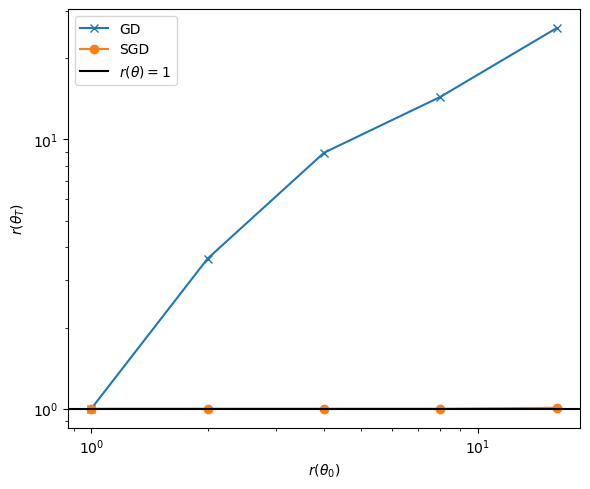

In [602]:
plt.figure(figsize=(6,5))

plt.loglog(rInit_gd, rT_gd, 'x-', label='GD')
plt.loglog(rInit_sgd, rT_sgd, 'o-', label='SGD')
plt.axhline(y=1.0, label=r'$r(\theta) = 1$', color='black')

plt.xlabel(r'$r(\theta_0)$')
plt.ylabel(r'$r(\theta_T)$')
plt.legend()
plt.tight_layout()
plt.show()


In this figure it's shown that SGD tends to choose balanced solutions no matter how unbalanced the initial distribution was. Unlike for GD, which doesn't have this property